In [2]:
!pip install ultralytics

   ---------------------------------------- 0.0/645.2 kB ? eta -:--:--
   --------------------------------------- 645.2/645.2 kB 39.7 MB/s eta 0:00:00


In [9]:
# import section

from PIL import Image, ImageFilter, ImageEnhance, ImageOps
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import torchvision.transforms as transforms

In [11]:
# Set execution backend (CPU/MPS/GPU)

device = (
    "cuda" if torch.cuda.is_available() # CUDA-capable GPUs
    else "mps" if torch.backends.mps.is_available() # For MacOS systems
    else "cpu"
)

print(f"Using {device} device")

Using cuda device


In [10]:
# Set up label encodings and data paths

label_encodings = ['bicycle', 'bus', 'car', 'motorbike', 'person']
data_paths = {
    "train": {
        "images": Path("./datasets/train/images"),
        "labels": Path("./datasets/train/labels"),
    },
    "test": {
        "images": Path("./datasets/test/images"),
        "labels": Path("./datasets/test/labels"),
    },
    "val": {
        "images": Path("./datasets/val/images"),
        "labels": Path("./datasets/val/labels"),
    },
}

In [11]:
# Create function to prepare input data

def data_sort(set_type):
    img_paths = [path.resolve() for path in data_paths[set_type]['images'].rglob('*')]
    targets = []
    for label_path in data_paths[set_type]['labels'].rglob('*'):
        with open(str(label_path), 'r') as fp:
            labels = []
            boxes = []
            target = {}
            for line in fp:
                data = line.strip().split(" ")
                labels.append(int(data.pop(0)))
                boxes.append([float(i) for i in data])
            target['labels'] = labels
            target['boxes'] = boxes
            targets.append(target)
    
    return img_paths, targets

In [ ]:
train_img_paths, train_targets = data_sort('train')
train_targets[0]

In [2]:
from ultralytics import YOLO

model = YOLO('yolov8n.yaml').load('yolov8n.pt')
yaml_path = Path('./datasets/data.yaml').resolve()
results = model.train(data=str(yaml_path), epochs=10, imgsz=640)


                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

In [34]:
images = Image.open(train_img_paths[5])
results = model(images)[0]


0: 640x640 1 bicycle, 15 cars, 10 motorbikes, 27.4ms
Speed: 1024.6ms preprocess, 27.4ms inference, 15.7ms postprocess per image at shape (1, 3, 640, 640)


In [35]:
results

ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'bicycle', 1: 'bus', 2: 'car', 3: 'motorbike', 4: 'person'}
orig_img: array([[[157, 143, 131],
        [163, 149, 137],
        [187, 171, 158],
        ...,
        [230, 187, 172],
        [245, 198, 184],
        [254, 207, 193]],

       [[161, 147, 135],
        [167, 153, 141],
        [174, 158, 145],
        ...,
        [222, 179, 164],
        [228, 183, 169],
        [232, 187, 173]],

       [[155, 141, 129],
        [174, 160, 148],
        [172, 156, 143],
        ...,
        [209, 168, 153],
        [205, 164, 149],
        [205, 162, 147]],

       ...,

       [[122, 134, 146],
        [124, 136, 148],
        [128, 140, 152],
        ...,
        [140, 155, 158],
        [138, 152, 158],
        [135, 149, 155]],

       [[121, 133, 145],
        [125, 137, 149],
        [129, 141, 153],
        ...,
        [140, 155, 158]

In [37]:
results.boxes.cls

tensor([2., 3., 2., 2., 2., 2., 2., 2., 2., 3., 3., 3., 2., 3., 3., 2., 3., 3., 2., 2., 3., 0., 2., 2., 3., 2.], device='cuda:0')

In [36]:
counter = 0
for label in results.boxes.cls:
    if label not in [0., 4.]:
        counter += 1

print(f"There are {counter} vehicles on the road")

There are 25 vehicles on the road


# Use Saved fine-tuned model

In [35]:
from ultralytics import YOLO
from PIL import Image
from pathlib import Path

In [36]:
# Load model with fine-tuned weights

data_yaml_path = Path('./datasets/data.yaml').resolve()
weight_pt_path = Path('./runs/detect/train9/weights/best.pt').resolve()
model = YOLO(str(weight_pt_path))

In [37]:
train_img_paths, train_targets = data_sort('test')

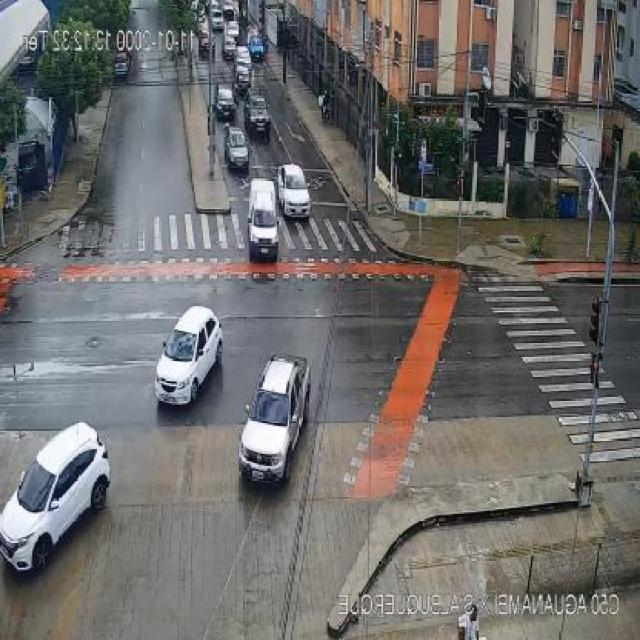

In [38]:
images = Image.open(train_img_paths[5])
images

In [47]:
results = model.predict(train_img_paths[5], imgsz=640, show=True, save=True, classes=[1, 2, 3], conf=0.5)


image 1/1 C:\Users\rahul\Desktop\Jupyter_Code\ML_NJIT\AI_Assignments\Traffic_Detection\datasets\test\images\aguanambi-1680_png_jpg.rf.fede1a51e422cc8fd628a4846615f65f.jpg: 640x640 14 cars, 25.2ms
Speed: 8.3ms preprocess, 25.2ms inference, 15.6ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs\detect\predict


In [48]:
counter = 0
for label in results[0].boxes.cls:
    if label not in [0., 4.]:
        counter += 1

print(f"There are {counter} vehicles on the road")

There are 14 vehicles on the road


In [44]:
results[0].boxes.cls

tensor([2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 2., 3., 3., 2., 2., 2.], device='cuda:0')

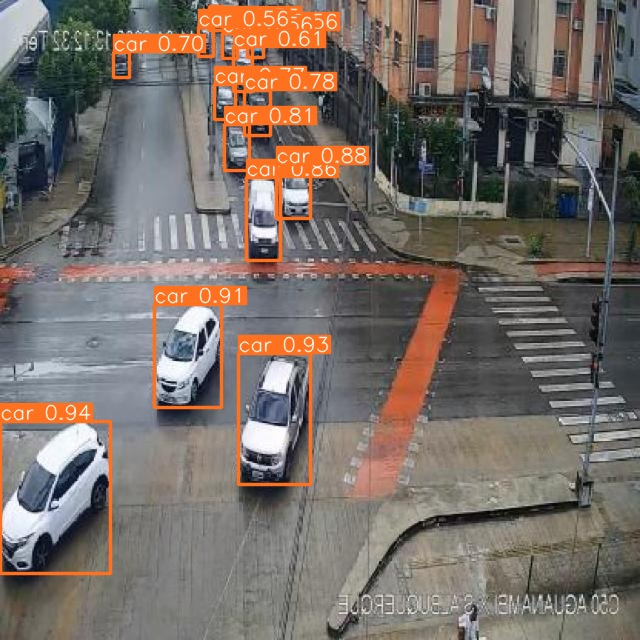

In [49]:
Image.open(Path('./runs/detect/predict/aguanambi-1680_png_jpg.rf.fede1a51e422cc8fd628a4846615f65f.jpg'))